In [1]:
import bokeh
from bokeh.plotting import figure, show, output_notebook
from bokeh.layouts import gridplot, row, column
from bokeh.models import FuncTickFormatter
import pandas as pd

In [2]:
output_notebook()

Loading BokehJS ...

#### Main Population Pyramid function

In [3]:
def pop_pyramid(dataframe, facet_col, facet_value, **kwargs):
    """
    Create a population pyramid plot for each facet value
    assuming the columns in the dataframe are called Age_Bands, Gender
    and Population.
    
    Returns a Bokeh plot object.
    """
    options = {
            'export': False,
            'title' : True,
            'xaxis' : False,
            'x_lim' : None,
            'stroke': True}
    
    options.update(kwargs)
    
    df = dataframe[dataframe[facet_col]==facet_value].copy()
    
    #Convert Age Bands to category type
    #and sort to make sure 0-4 is followed by 5-9 and not 10-14.
    
    df.loc[:,'Age_Bands'] = df['Age_Bands'].astype('category')
    df['Age_Bands'].cat.reorder_categories(
                                sorted(df['Age_Bands'].unique(), key=lambda x:int(x[:2])),
                                inplace=True, ordered=True)
    df.sort_values('Age_Bands', inplace=True) 
    
    #offset of 0.015 works well for % of total; for absolute use df['Population'].max() * 0.1
    offset = df['Population'].max() * 0.1
    #x_lim of 0.1 works well for % of total; for absolute use df['Population'].max() * 1.2
    #if you need a consistent x limit, pass it into the function
        
    if options['x_lim'] == None:
        x_lim = df['Population'].max() * 1.2
    else:
        x_lim = options['x_lim']
    
    y_lim = len(df['Age_Bands'].unique())
    y_text = df.Age_Bands.unique()

    total = df['Population'].sum()
    total_male = df[df['Gender'] == 'Male']['Population'].sum()
    total_female = df[df['Gender'] == 'Female']['Population'].sum()

    #switch between % of total and raw values: (-x/total) or just -x
    x_male = ([-x - offset for x in df[df['Gender'] == 'Male']
               .Population
               .values])
    x_female = ([x + offset for x in df[df['Gender'] == 'Female']
                 .Population
                 .values])
    
    #y_range for plots (not figure) starts with 1 not 0 to "lift up" the plot a little bit
    p = figure(plot_width=600, plot_height=400, x_range=(-x_lim, x_lim), y_range=(0, y_lim+1))
    
    stroke = 'solid'
    stroke_color = 'black'
    stroke_width = 0.5
    
    if not options['stroke']:
        stroke = None
        stroke_color = None
        stroke_width = None

    male_bar = p.hbar(y=range(1,y_lim+1), height=0.5, right=x_male, color="#bebada",
            left=-offset, line_dash=stroke, line_color=stroke_color, line_width=stroke_width)
    female_bar = p.hbar(y=range(1,y_lim+1), height=0.5, right=x_female, color="#8dd3c7",
            left=offset, line_dash=stroke, line_color=stroke_color, line_width=stroke_width)
    text = p.text(x=[0]*y_lim, y=range(1,y_lim+1), text=y_text,
            text_align='center', y_offset=8, text_font_size="11px")

    #Set default formatting options
    p.grid.visible = False
    p.yaxis.visible = False
    p.outline_line_color = 'darkgrey'
    p.toolbar.logo = None
    p.toolbar_location = None
    p.xaxis[0].formatter = FuncTickFormatter(code="""
    return Math.abs(tick)""")
    
    if not options['xaxis']:
        p.xaxis.visible = False        
    
    #Set title options
    if options['title']:
        p.title.text = str(facet_value)
        p.title.align = 'center'
        
    #Control exporting behaviour
    if options['export']:
        bokeh.io.export_png(p, filename='pp_{}.png'.format(facet_value))

    return p

#### Create a plot for each of the 32 council areas

In [4]:
#Data Frame with all 32 council areas
df = pd.read_csv('data/ca_pyramid_data.csv')
data = (df.groupby(['Age_Bands', 'Area', 'Gender'])['Population']
        .sum()
        .reset_index(name='Population'))

In [5]:
#test for a single area
show(pop_pyramid(data, 'Area', 'City of Edinburgh', xaxis=True,
                 export=False, title=True))

In [ ]:
#iterate over areas to produce a plot for each and then layout them in a grid
plots = []
for ca in data['Area'].unique():
    plots.append(pop_pyramid(data,'Area',ca))

plot_grid = gridplot(plots, ncols=5)
#uncomment the lines below to export or show in the notebook
#bokeh.io.export_png(plot_grid, filename='images/all_ca_no_name.png')
#show(plot_grid)

#### Create a pyramid plot for 2001 and 2009 population of Uist

In [6]:
df = pd.read_csv('data/uist_2001-9.csv')

In [7]:
show(pop_pyramid(df, 'Year', 2009, title=True,
                 xaxis=True, x_lim=260, export=False, stroke=True))

#### Create pop_pyramids of Scotland in 2001-2009-2016

In [ ]:
scot = pd.read_csv('data/scot_2001-9-16_clean.csv')

In [ ]:
show(pop_pyramid(scot, 'Year', 2016, title=True,
                 xaxis=True, export=False, x_lim=250000, stroke=True))

#### Compare images of population pyramids to find shapes similar to Uist

In [8]:
%matplotlib inline

In [9]:
from imageio import imread
from scipy.linalg import norm
from scipy import sum, average
from pathlib import Path
import os

In [10]:
#code adapted from:
#https://stackoverflow.com/questions/189943/
#how-can-i-quantify-difference-between-two-images#3935002
def to_grayscale(arr):
    "If arr is a color image (3D array), convert it to grayscale (2D array)."
    if len(arr.shape) == 3:
        return average(arr, -1)
    else:
        return arr

def compare_images(img1, img2):
    # calculate the difference and its norms
    diff = img1 - img2
    m_norm = sum(abs(diff)) # Manhattan norm
    z_norm = norm(diff.ravel(), 0) # Zero norm
    return (m_norm, z_norm)

def main(file1, file2):
    # read images as 2D arrays (convert to grayscale for simplicity)
    img1 = to_grayscale(imread(file1).astype(float))
    img2 = to_grayscale(imread(file2).astype(float))
    # compare
    n_m, n_0 = compare_images(img1, img2)
    return n_m    
    #print ("Manhattan norm:", n_m, "/ per pixel:", n_m/img1.size)
    #print ("Zero norm:", n_0, "/ per pixel:", n_0*1.0/img1.size)

In [11]:
ref_image = 'images/pp_Uist.png'
comp_images = ['images/compare/' + x for x in os.listdir('images/compare')]

In [12]:
image_dict = {}
#extract area name from filename and pair it with the output of the compare function
for image in comp_images:
    image_dict[image[18:-4]] = main(ref_image, image)

sorted_dict = sorted(image_dict, key=lambda x : image_dict[x])

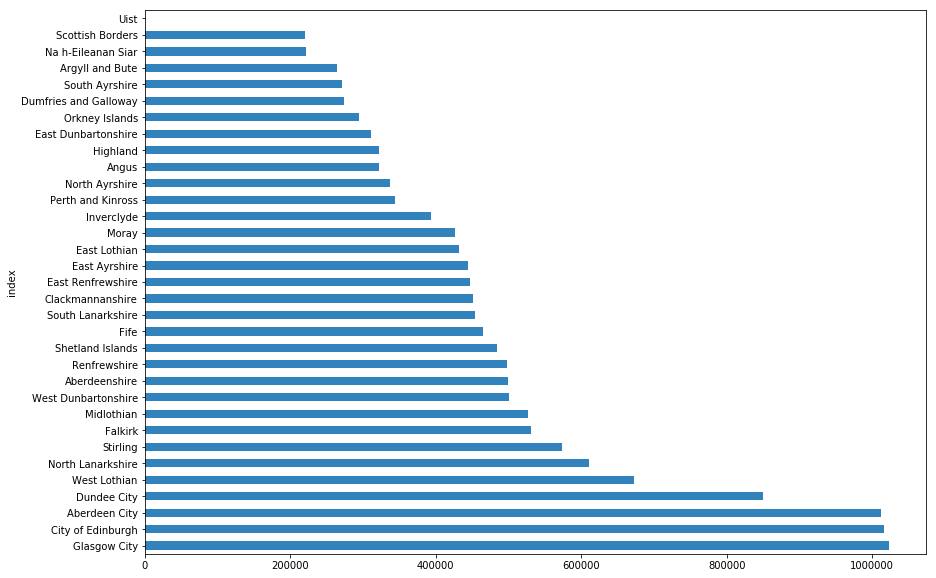

In [13]:
#visualise the differences from Uist for each council area
like_df = (pd.DataFrame.from_dict(image_dict, orient='index', columns=['Value'])
            .reset_index()
            .sort_values('Value', ascending=False))

like_df.plot(x='index', y='Value', kind='barh', legend=False, 
             figsize=(14,10), colormap='tab20c')

#### Get the image resulting from the difference of two images

In [ ]:
from PIL import ImageChops, Image

In [ ]:
img_1 = Image.open('images/Scotland_2001.png').convert('RGB')
img_2 = Image.open('images/Scotland_2016.png').convert('RGB')

In [ ]:
diff = ImageChops.difference(img_1, img_2)

In [ ]:
diff.save('images/Scot_2001vs20016_diff.png')